# 05b: CNN-LSTM Model Design and Training
---
This notebook provides a comprehensive workflow for designing, training, and saving a hybrid CNN-LSTM model for ICU mortality prediction.

**Goals:**
- Build a deep learning model that leverages both dynamic (time series) and static patient features
- Implement a robust architecture combining CNN and LSTM layers for clinical time series analysis
- Train the model using best practices (early stopping, checkpointing, multiple metrics)
- Save the trained model and training history for reproducibility and future evaluation
- Lay the foundation for downstream evaluation, interpretation, and clinical application

## Workflow Overview
1. **Importing Libraries & Configuration**: Set up the environment and import required packages.
2. **Loading and Validating Data**: Load preprocessed time series and static features, and confirm their shapes.
3. **Model Architecture**: Define a hybrid CNN-LSTM model for ICU mortality prediction, combining sequence and static features.
4. **Model Training**: Train the model using early stopping and checkpointing to prevent overfitting.
5. **Saving Results**: Save the trained model and training history for future evaluation.
---

## 1. Import Libraries and Configure Environment
First, we import all necessary libraries for model building, training, and saving. Setting random seeds ensures reproducibility.

In [2]:
# Imports and Configuration
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
import shap
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load and Validate Data

We load preprocessed time series and static features for training, validation, and testing. Shapes are printed to confirm the data.


In [3]:
# Load prepared data 
data = np.load('../data/processed/cnn_lstm_data.npz', allow_pickle=True)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']
static_train, static_val, static_test = data['static_train'], data['static_val'], data['static_test']

# print shapes to confirm alignment
print('X_train shape:', X_train.shape)
print('static_train shape:', static_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('static_val shape:', static_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('static_test shape:', static_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4406, 202, 24)
static_train shape: (4406, 9)
y_train shape: (4406,)
X_val shape: (640, 202, 24)
static_val shape: (640, 9)
y_val shape: (640,)
X_test shape: (800, 202, 24)
static_test shape: (800, 9)
y_test shape: (800,)


## 3. Model Architecture: CNN-LSTM Hybrid

This section defines a hybrid deep learning model that combines convolutional neural networks (CNN) and long short-term memory (LSTM) layers for ICU mortality prediction. The architecture is designed to leverage both temporal patterns in time series data and static patient features.

**Key Design Choices:**
- **CNN Layers:** Extract local temporal features from the time series input, capturing short-term dependencies and patterns.
- **LSTM Layer:** Captures long-term dependencies and trends in the sequential data, which are important for patient outcome prediction.
- **Static Input:** Patient static features (e.g., demographics, baseline measurements) are included as a separate input and concatenated with the sequence features after feature extraction.
- **Dense Layers:** Combine the extracted sequence and static features to learn complex interactions.
- **Regularization:** Dropout and L2 regularization are used to prevent overfitting and improve generalization.
- **Output Layer:** A single neuron with sigmoid activation for binary classification (mortality prediction).

**Inputs:**
- Time series features: shape = [batch, timesteps, features]
- Static features: shape = [batch, static_features]

**Output:**
- Binary prediction: 0 = survived, 1 = deceased

This architecture is well-suited for clinical time series tasks where both dynamic and static patient information are available.


In [4]:
# Model definition
# --- Sequence Input ---
# Input layer for time series data (e.g., vital signs, labs)
seq_input = Input(shape=(X_train.shape[1], X_train.shape[2]), name='seq_input')

# First CNN layer: captures local temporal patterns
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(seq_input)
x = Dropout(0.3)(x)

# Second CNN layer: further feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

# LSTM layer: captures long-term dependencies in the sequence
x = LSTM(64, return_sequences=False, kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

# --- Static Input ---
# Input layer for static patient features (e.g., age, gender)
static_input = Input(shape=(static_train.shape[1],), name='static_input')

# --- Feature Combination ---
# Concatenate sequence and static features
concat = Concatenate()([x, static_input])

# Dense layer: learns interactions between sequence and static features
# Regularized to prevent overfitting
dense = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(concat)

# Output layer: binary prediction (mortality)
output = Dense(1, activation='sigmoid')(dense)

# Build and compile the model
model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'Precision', 'Recall'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 202, 24)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 202, 64)   │      4,672 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 202, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 202, 64)   │     12,352 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 202, 64)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 73)        │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,368 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,449 (204.88 KB)

 Trainable params: 52,449 (204.88 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Model

This step trains the CNN-LSTM model using best practices to ensure robust performance and prevent overfitting.

**Training Strategies:**
- **Early Stopping:** Monitors validation loss and stops training if it does not improve for 10 epochs, restoring the best weights. This helps avoid overfitting and unnecessary computation.
- **Model Checkpointing:** Saves the model weights whenever validation loss improves, ensuring the best model is retained for later evaluation.
- **Metrics Tracked:**
  - **AUC (Area Under Curve):** Measures the ability of the model to distinguish between classes.
  - **Precision:** Fraction of true positives among predicted positives.
  - **Recall:** Fraction of true positives among actual positives.
- **Batch Size & Epochs:** Batch size of 64 balances memory and convergence speed; up to 100 epochs allows for thorough training but is limited by early stopping.

**Validation:**
- Validation data is used to monitor generalization performance during training.

This approach ensures the model is both accurate and generalizes well to unseen data.


In [5]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('../models/cnn_lstm_best_model.keras', save_best_only=True)  # Use .keras format
]

history = model.fit(
    [X_train, static_train], y_train,
    validation_data=([X_val, static_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - AUC: 0.8754 - Precision: 0.7916 - Recall: 0.7812 - loss: 0.5525 - val_AUC: 0.9668 - val_Precision: 0.4098 - val_Recall: 0.9438 - val_loss: 0.4987
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - AUC: 0.8754 - Precision: 0.7916 - Recall: 0.7812 - loss: 0.5525 - val_AUC: 0.9668 - val_Precision: 0.4098 - val_Recall: 0.9438 - val_loss: 0.4987
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - AUC: 0.9723 - Precision: 0.9220 - Recall: 0.9278 - loss: 0.3773 - val_AUC: 0.9884 - val_Precision: 0.6304 - val_Recall: 0.9775 - val_loss: 0.3485
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - AUC: 0.9723 - Precision: 0.9220 - Recall: 0.9278 - loss: 0.3773 - val_AUC: 0.9884 - val_Precision: 0.6304 - val_Recall: 0.9775 - val_loss: 0.3485
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - AUC: 0.9879 - Precision: 0.9477 - Recall: 0.9709 - loss: 0.2712 - val_AUC: 0.9941 - val_Precision: 0.6953 - val_Recall: 1.0000 - val_loss: 0.260

## 5. Save Model and Training History

After training, it is essential to save both the final model and the training history:

- **Model File:** The trained model is saved in the modern `.keras` format, which is recommended for future loading and inference. This allows you to deploy or further evaluate the model without retraining.
- **Training History:** The training history (loss and metrics per epoch) is saved as a pickle file. This enables you to analyze training dynamics, plot learning curves, and compare different model runs.
- **Reproducibility:** Saving these artifacts ensures that results can be reproduced and shared with collaborators or for publication.

Both files are stored in the `models` directory for easy access and organization.


In [6]:
# Save model and training history
model.save('../models/cnn_lstm_final_model.keras')  # Save model in .keras format
with open('../models/cnn_lstm_history.pkl', 'wb') as f:  # Save history for optimization notebook
    pickle.dump(history.history, f)
print("Model and training history saved to ../models/ directory.")

Model and training history saved to ../models/ directory.


## 6. Plot Training History

Visualize the training and validation accuracy and loss curves to evaluate the model's performance over epochs. This helps in understanding the model's learning behavior, detecting potential overfitting, and comparing different model configurations.


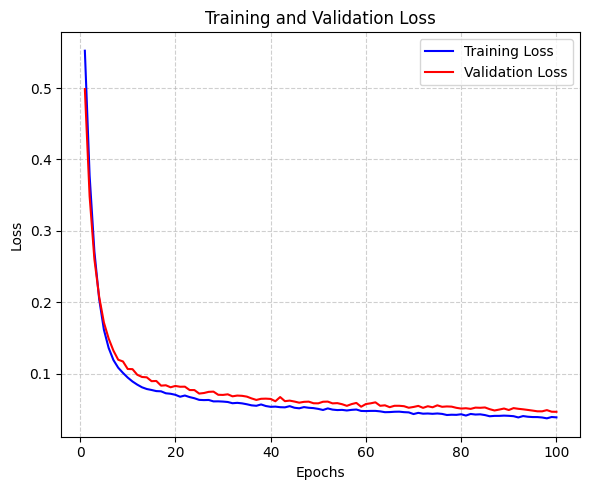

No suitable training history metrics (Accuracy, AUC, Precision, Recall) found. Only loss curves are plotted.


In [7]:
# Plot training and validation metrics and loss curves
# Try accuracy first, then AUC, Precision, Recall
metrics_to_try = [
    ('accuracy', 'val_accuracy', 'Accuracy'),
    ('auc', 'val_auc', 'AUC'),
    ('precision', 'val_precision', 'Precision'),
    ('recall', 'val_recall', 'Recall')
]

metric_found = False
for train_key, val_key, metric_name in metrics_to_try:
    train_metric = history.history.get(train_key)
    val_metric = history.history.get(val_key)
    if train_metric is not None and val_metric is not None:
        epochs = range(1, len(train_metric) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_metric, 'b-', label=f'Training {metric_name}')
        plt.plot(epochs, val_metric, 'r-', label=f'Validation {metric_name}')
        plt.title(f'Training and Validation {metric_name}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        metric_found = True
        break

loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
if loss is not None and val_loss is not None:
    if metric_found:
        # epochs already defined above
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'b-', label='Training Loss')
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        # Define epochs based on loss if no metric was found
        epochs = range(1, len(loss) + 1)
        plt.figure(figsize=(6, 5))
        plt.plot(epochs, loss, 'b-', label='Training Loss')
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        print("No suitable training history metrics (Accuracy, AUC, Precision, Recall) found. Only loss curves are plotted.")
else:
    print("No training history metrics available for plotting. Please check the keys in history.history.")

## Diagnostic: Check Static Feature Scaling and Input Shapes

Before training the model, it's crucial to ensure that static features are properly scaled and input shapes are correct. This diagnostic check prints the mean and standard deviation of the static features for the training, validation, and test sets. It also confirms the shapes of the static feature arrays.

**Expected Output:**
- Means and standard deviations should be similar across training, validation, and test sets if scaling is consistent.
- Shapes should match the expected input dimensions for the model.


In [8]:
# Diagnostic: Check static feature scaling and input shapes
print('Static train mean:', np.mean(static_train, axis=0))
print('Static train std:', np.std(static_train, axis=0))
print('Static val mean:', np.mean(static_val, axis=0))
print('Static val std:', np.std(static_val, axis=0))
print('Static test mean:', np.mean(static_test, axis=0))
print('Static test std:', np.std(static_test, axis=0))
print('Static train shape:', static_train.shape)
print('Static val shape:', static_val.shape)
print('Static test shape:', static_test.shape)

Static train mean: [ 0.11808301 -0.01706707 -0.00855868 -0.0486917   0.05761664  0.19879337
  0.19402692 -0.00510013 -0.69332251]
Static train std: [0.97125604 1.00172628 0.88277489 1.04854978 0.98824499 1.02087733
 1.09140454 1.06794271 1.19486655]
Static val mean: [-0.00806417  0.03484581  0.14750915 -0.0618537   0.01465928 -0.04496439
  0.02432483  0.07199057  0.04634876]
Static val std: [0.99547307 0.99555808 1.7539958  0.94983894 1.00620605 1.01592676
 0.9626333  1.05039094 1.02946939]
Static test mean: [-0.02227951  0.0486784   0.04733636 -0.05409006  0.0482046   0.03934183
  0.0640941  -0.00238893  0.01159913]
Static test std: [0.99331187 0.99345045 1.57180277 0.93493361 0.97751697 1.05427254
 1.0263099  1.02478319 0.99894358]
Static train shape: (4406, 9)
Static val shape: (640, 9)
Static test shape: (800, 9)


## Compute and Plot SHAP Feature Importances

SHAP (SHapley Additive exPlanations) values provide insights into feature importances for the CNN-LSTM model. This section computes and visualizes the SHAP values for the test set, helping to interpret the model's predictions.

- **Subset for SHAP:** Due to computational cost, a subset of the data is used for SHAP value computation.
- **Model Prediction Function:** A custom function to predict outputs from the model given the inputs.
- **SHAP Kernel Explainer:** Used to estimate the SHAP values for the input features.
- **Feature Names:** Sequence and static feature names are combined for comprehensive labeling.

The resulting plot shows the impact of each feature on the model's output, aiding in understanding and interpreting the model's decisions.


In [9]:
# Compute and plot SHAP feature importances
# Use a subset for SHAP due to computational cost
X_shap_seq = X_test[:100]
static_shap = static_test[:100]

def model_predict(inputs):
    seq, static = inputs[:, :X_shap_seq.shape[2]], inputs[:, X_shap_seq.shape[2]:]
    seq_reshaped = np.repeat(seq[:, np.newaxis, :], X_shap_seq.shape[1], axis=1)
    return model.predict([seq_reshaped, static])

# Prepare SHAP input: average time-series over time axis, then concatenate with static
X_shap_seq_mean = np.mean(X_shap_seq, axis=1)
shap_input = np.concatenate([X_shap_seq_mean, static_shap], axis=1)

import shap

explainer = shap.KernelExplainer(model_predict, shap_input)
shap_values = explainer.shap_values(shap_input, nsamples=100)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
160/313 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


  1%|          | 1/100 [00:06<11:22,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


  2%|▏         | 2/100 [00:13<11:18,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


  3%|▎         | 3/100 [00:21<11:33,  7.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


  4%|▍         | 4/100 [00:28<11:31,  7.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


  5%|▌         | 5/100 [00:36<11:33,  7.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


  6%|▌         | 6/100 [00:42<11:10,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


  7%|▋         | 7/100 [00:49<10:53,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


  8%|▊         | 8/100 [00:56<10:42,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


  9%|▉         | 9/100 [01:03<10:38,  7.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 10%|█         | 10/100 [01:10<10:25,  6.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 11%|█         | 11/100 [01:17<10:16,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 12%|█▏        | 12/100 [01:24<10:10,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 13%|█▎        | 13/100 [01:31<10:15,  7.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 14%|█▍        | 14/100 [01:39<10:19,  7.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 15%|█▌        | 15/100 [01:46<10:09,  7.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 16%|█▌        | 16/100 [01:52<09:51,  7.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 17%|█▋        | 17/100 [01:59<09:41,  7.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 18%|█▊        | 18/100 [02:06<09:31,  6.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


 19%|█▉        | 19/100 [02:13<09:16,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


 20%|██        | 20/100 [02:20<09:04,  6.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 21%|██        | 21/100 [02:26<08:55,  6.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 22%|██▏       | 22/100 [02:33<08:49,  6.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


 23%|██▎       | 23/100 [02:40<08:39,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 24%|██▍       | 24/100 [02:46<08:32,  6.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 25%|██▌       | 25/100 [02:53<08:26,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 26%|██▌       | 26/100 [03:00<08:21,  6.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 27%|██▋       | 27/100 [03:07<08:14,  6.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


 28%|██▊       | 28/100 [03:13<08:04,  6.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 29%|██▉       | 29/100 [03:20<07:58,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 30%|███       | 30/100 [03:28<08:02,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 31%|███       | 31/100 [03:35<08:02,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 32%|███▏      | 32/100 [03:42<07:53,  6.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 33%|███▎      | 33/100 [03:48<07:44,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


 34%|███▍      | 34/100 [03:56<07:40,  6.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


 35%|███▌      | 35/100 [04:03<07:35,  7.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 36%|███▌      | 36/100 [04:10<07:38,  7.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 37%|███▋      | 37/100 [04:17<07:28,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 38%|███▊      | 38/100 [04:24<07:16,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 39%|███▉      | 39/100 [04:31<07:06,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 40%|████      | 40/100 [04:38<06:56,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 41%|████      | 41/100 [04:45<06:48,  6.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 42%|████▏     | 42/100 [04:51<06:40,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 43%|████▎     | 43/100 [04:59<06:38,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 44%|████▍     | 44/100 [05:06<06:30,  6.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 45%|████▌     | 45/100 [05:12<06:20,  6.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 46%|████▌     | 46/100 [05:19<06:16,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 47%|████▋     | 47/100 [05:26<06:10,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 48%|████▊     | 48/100 [05:33<06:01,  6.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 49%|████▉     | 49/100 [05:40<05:52,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 50%|█████     | 50/100 [05:47<05:44,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 51%|█████     | 51/100 [05:54<05:39,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 52%|█████▏    | 52/100 [06:01<05:40,  7.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 53%|█████▎    | 53/100 [06:08<05:31,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


 54%|█████▍    | 54/100 [06:16<05:24,  7.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 55%|█████▌    | 55/100 [06:23<05:26,  7.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


 56%|█████▌    | 56/100 [06:33<05:47,  7.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


 57%|█████▋    | 57/100 [06:41<05:44,  8.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


 58%|█████▊    | 58/100 [06:49<05:33,  7.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 59%|█████▉    | 59/100 [06:56<05:15,  7.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 60%|██████    | 60/100 [07:03<04:57,  7.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


 61%|██████    | 61/100 [07:10<04:45,  7.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 62%|██████▏   | 62/100 [07:17<04:36,  7.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 63%|██████▎   | 63/100 [07:24<04:27,  7.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


 64%|██████▍   | 64/100 [07:32<04:26,  7.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 65%|██████▌   | 65/100 [07:39<04:17,  7.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


 66%|██████▌   | 66/100 [07:47<04:13,  7.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


 67%|██████▋   | 67/100 [07:55<04:09,  7.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


 68%|██████▊   | 68/100 [08:03<04:06,  7.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 69%|██████▉   | 69/100 [08:10<03:57,  7.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 70%|███████   | 70/100 [08:18<03:49,  7.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 71%|███████   | 71/100 [08:25<03:39,  7.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 72%|███████▏  | 72/100 [08:33<03:31,  7.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 73%|███████▎  | 73/100 [08:40<03:20,  7.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


 74%|███████▍  | 74/100 [08:47<03:15,  7.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


 75%|███████▌  | 75/100 [08:55<03:04,  7.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 76%|███████▌  | 76/100 [09:02<02:55,  7.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 77%|███████▋  | 77/100 [09:09<02:47,  7.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 78%|███████▊  | 78/100 [09:16<02:40,  7.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 79%|███████▉  | 79/100 [09:23<02:32,  7.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 80%|████████  | 80/100 [09:31<02:24,  7.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 81%|████████  | 81/100 [09:38<02:16,  7.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 82%|████████▏ | 82/100 [09:45<02:08,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 83%|████████▎ | 83/100 [09:52<01:59,  7.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 84%|████████▍ | 84/100 [09:59<01:53,  7.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 85%|████████▌ | 85/100 [10:06<01:48,  7.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 86%|████████▌ | 86/100 [10:14<01:43,  7.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 87%|████████▋ | 87/100 [10:21<01:34,  7.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 88%|████████▊ | 88/100 [10:28<01:26,  7.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 89%|████████▉ | 89/100 [10:35<01:18,  7.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 90%|█████████ | 90/100 [10:42<01:11,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 91%|█████████ | 91/100 [10:49<01:03,  7.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


 92%|█████████▏| 92/100 [10:56<00:56,  7.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


 93%|█████████▎| 93/100 [11:03<00:49,  7.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 94%|█████████▍| 94/100 [11:11<00:42,  7.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 95%|█████████▌| 95/100 [11:18<00:35,  7.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


 96%|█████████▌| 96/100 [11:25<00:28,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


 97%|█████████▋| 97/100 [11:32<00:21,  7.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


 98%|█████████▊| 98/100 [11:40<00:14,  7.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


 99%|█████████▉| 99/100 [11:48<00:07,  7.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


100%|██████████| 100/100 [11:55<00:00,  7.15s/it]


In [ ]:
# Feature names
sequence_feature_names = [
 'DiasABP', 'MAP''NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent',
    'RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2',
    'Creatinine', 'BUN', 'Urine',
    'Na', 'K', 'Glucose', 'Lactate', 'HCO3', 'pH',
    'GCS', 'Temp'
]
import matplotlib.pyplot as plt
import shap
# for each of the feature plot the SHAP values
for i, feature in enumerate(sequence_feature_names):
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(i, shap_values, shap_input, feature_names=sequence_feature_names)
    plt.title(f'SHAP Dependence Plot for {feature}')
    plt.tight_layout()
    plt.savefig(f'../figures/shap_dependence_{feature}.png')
    plt.show()


C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'shap_values' is not defined

<Figure size 1000x600 with 0 Axes>